### Stereo Disparity 03

##### Import statements

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from helper import *
from skimage.metrics import structural_similarity

##### Loading images and true disparity maps

Left Camera Matrix
[[1.73374e+03 0.00000e+00 7.92270e+02]
 [0.00000e+00 1.73374e+03 5.41890e+02]
 [0.00000e+00 0.00000e+00 1.00000e+00]]
Right Camera Matrix
[[1.73374e+03 0.00000e+00 7.92270e+02]
 [0.00000e+00 1.73374e+03 5.41890e+02]
 [0.00000e+00 0.00000e+00 1.00000e+00]]
Baseline: 536.62
Image Size (Width, Height): (1920.0, 1080.0)
Conservative Bound of Disparity Levels: [0, 169.0]
Tight Bound of Min and Max Disparities: [55.0, 142.0]


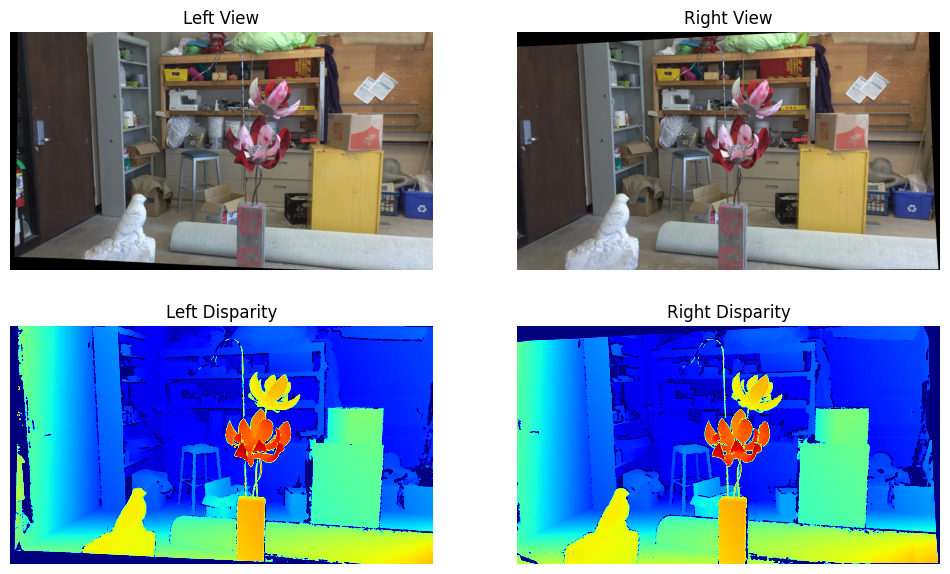

In [2]:
path = "2021 mobile datasets/artroom1"

calib = read_calib( f"{ path}/calib.txt")
disp_L, scale = read_pfm( f"{ path}/disp0.pfm")
disp_R, _ = read_pfm( f"{ path}/disp1.pfm")
img_L_orig = Image.open( f"{ path}/im0.png")
img_R_orig = Image.open( f"{ path}/im1.png")
img_L = np.array( img_L_orig.convert( "L"))
img_R = np.array( img_R_orig.convert( "L"))

print_calib( calib)

display( img_L_orig, img_R_orig, disp_L, disp_R, scale, calib[ "vmin"], calib[ "vmax"])

##### Resizing images

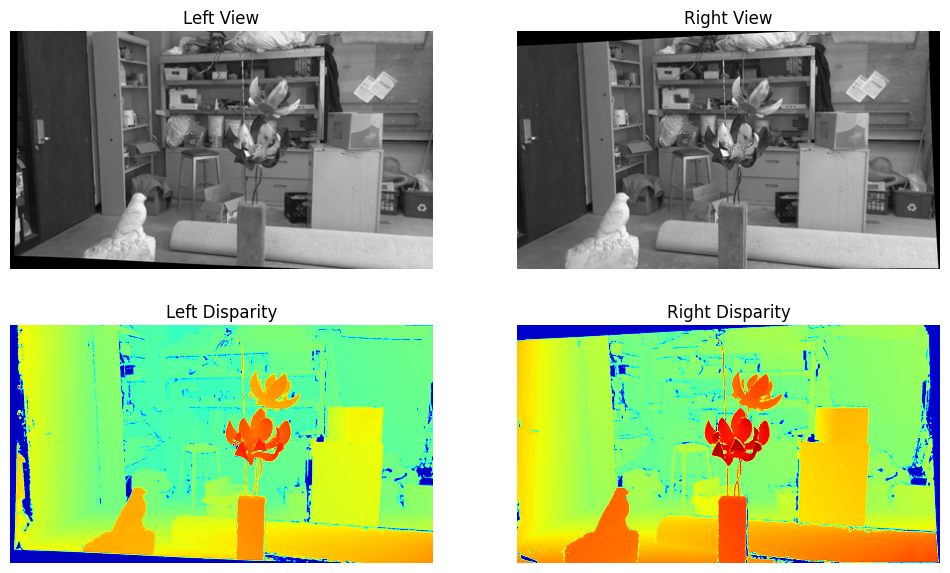

In [3]:
# Almost Quarter of Original Size
new_size = ( 427, 240)

ndisp_resized = int( calib[ "ndisp"] / 4)

disp_L_resized = np.array( Image.fromarray( disp_L).resize( new_size))
disp_R_resized = np.array( Image.fromarray( disp_R).resize( new_size))

img_L_resized = np.array( Image.fromarray( img_L).resize( new_size))
img_R_resized = np.array( Image.fromarray( img_R).resize( new_size))

fig = plt.figure( figsize=( 12, 7))

fig.add_subplot( 2, 2, 1)
plt.imshow( img_L_resized, cmap="gray")
plt.title( "Left View")
plt.axis( "off")

fig.add_subplot( 2, 2, 2)
plt.imshow( img_R_resized, cmap="gray")
plt.title( "Right View")
plt.axis( "off")

fig.add_subplot( 2, 2, 3)
plt.imshow( disp_L_resized, cmap="jet")
plt.title( "Left Disparity")
plt.axis( "off")

fig.add_subplot( 2, 2, 4)
plt.imshow( disp_R_resized, cmap="jet")
plt.title( "Right Disparity")
plt.axis( "off")

plt.show()

##### Scale the range of true resized disparity into [0-1]

In [4]:
disp_L_resized_scaled = np.float32( disp_L_resized - disp_L_resized.min()) / np.float32( disp_L_resized.max())

disp_R_resized_scaled = np.float32( disp_R_resized - disp_R_resized.min()) / np.float32( disp_R_resized.max())

##### SIFT feature detection

- Detect and compute features

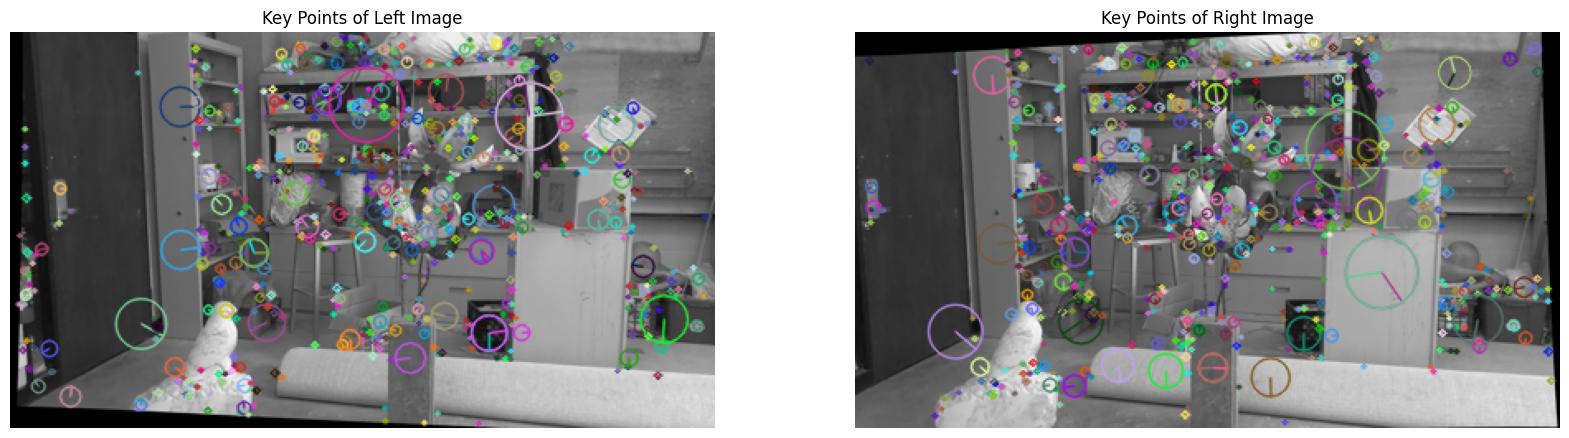

In [5]:
sift = cv2.SIFT_create()

kp_L, desc_L = sift.detectAndCompute( img_L_resized, None)
kp_R, desc_R = sift.detectAndCompute( img_R_resized, None)

img_kp_L = cv2.drawKeypoints( img_L_resized, kp_L, np.copy( img_L_resized), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img_kp_R = cv2.drawKeypoints( img_R_resized, kp_R, np.copy( img_R_resized), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

fig = plt.figure( figsize=( 20, 10))

fig.add_subplot( 1, 2, 1)
plt.imshow( img_kp_L)
plt.title( "Key Points of Left Image")
plt.axis( "off")

fig.add_subplot( 1, 2, 2)
plt.imshow( img_kp_R)
plt.title( "Key Points of Right Image")
plt.axis( "off")

plt.show()

- Match good features

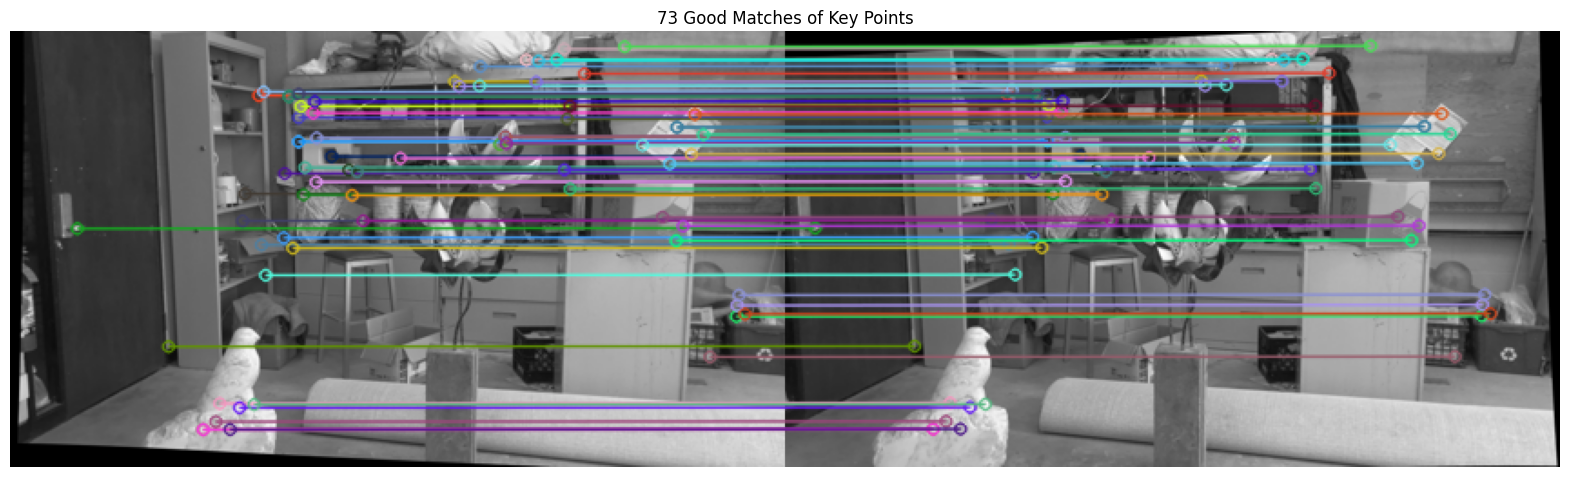

In [6]:
bf = cv2.BFMatcher()
matches = bf.knnMatch( desc_L, desc_R, k=2)

good = []

for m, n in matches:
	if m.distance < 0.2 * n.distance:
		good.append( [ m])

points_L = np.float32( [ kp_L[ m[ 0].queryIdx].pt for m in good])
points_R = np.float32( [ kp_R[ m[ 0].trainIdx].pt for m in good])

img_match_kp = cv2.drawMatchesKnn( img_L_resized, kp_L, img_R_resized, kp_R, good, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure( figsize=( 20, 10))
plt.title( f"{ len( good)} Good Matches of Key Points")
plt.imshow( img_match_kp)
plt.axis( "off")
plt.show()

##### Fundamental matrix

- Normalization

In [7]:
L_mean_x, L_mean_y = np.mean( points_L, axis=0)
R_mean_x, R_mean_y = np.mean( points_R, axis=0)

points_L_augmented = np.c_[ points_L, np.ones( len( points_L))]
points_R_augmented = np.c_[ points_R, np.ones( len( points_R))]

# Subtract Mean & Divide x and y By mean_x / 2 and mean_y / 2
T_L = np.array( [
	[ 2 / L_mean_x, 0, -2],
	[ 0, 2 / L_mean_y, -2],
	[ 0, 0, 1]
])

T_R = np.array( [
	[ 2 / R_mean_x, 0, -2],
	[ 0, 2 / R_mean_y, -2],
	[ 0, 0, 1]
])

points_L_normalized = np.dot( T_L, points_L_augmented.T).T
points_R_normalized = np.dot( T_R, points_R_augmented.T).T

- Construct observation matrix

In [8]:
observations = []

for point_L, point_R in zip( points_L_normalized, points_R_normalized):
	x_L, y_L, _ = point_L
	x_R, y_R, _ = point_R
	o = [
		x_L * x_R,
		x_L * y_R,
		x_L,
		y_L * x_R,
		y_L * y_R,
		y_L,
		x_R,
		y_R,
		1
	]

	observations.append( o)

observations = np.array( observations)

- Finding fundamental matrix using SVD

In [9]:
U, S, V = np.linalg.svd( observations)

F = np.reshape( V[ -1, :], ( 3, 3))

u, s, v = np.linalg.svd( F)

s = np.diag( s)

s[ 2, 2] = 0

F = np.dot( np.dot( u, s), v)

F = np.dot( np.dot( T_R.T, F), T_L)

F = F / F[ -1, -1]

print( "Fundamental Matrix:")
print( F)

Fundamental Matrix:
[[ 4.38962197e-08 -1.32852593e-04  1.47803287e-02]
 [ 1.18833875e-04  8.10138244e-06 -1.90465999e+00]
 [-1.37676872e-02  1.88386133e+00  1.00000000e+00]]


- Finding essential matrix

In [10]:
M_L = np.array( calib[ "cam0"])
M_R = np.array( calib[ "cam1"])

E = np.dot( np.dot( M_R.T, F), M_L)

print( "Essential Matrix:")
print( E)

Essential Matrix:
[[ 1.31945644e-01 -3.99335551e+02 -9.91289866e+01]
 [ 3.57197323e+02  2.43515760e+01 -3.13134494e+03]
 [ 8.78346990e+01  3.09125194e+03 -1.30803778e+01]]


##### Showing Epipolar line of a sample point

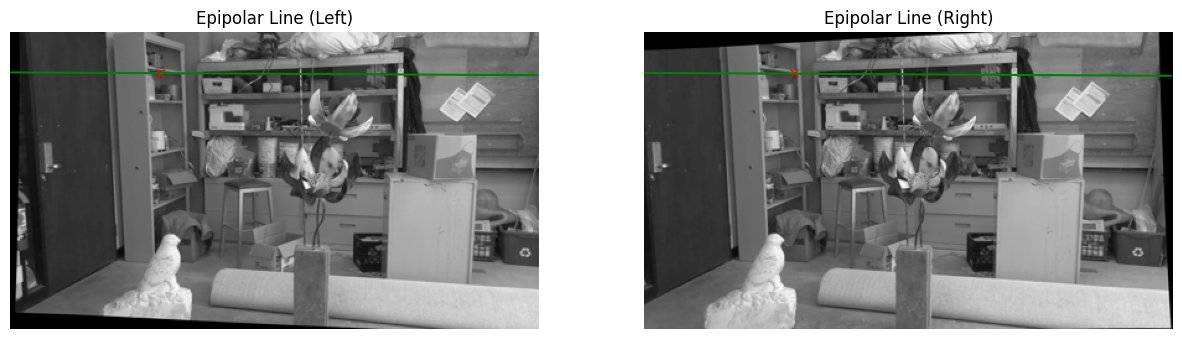

In [11]:
point = [
	np.random.randint( 0, img_L_resized.shape[ 1]),
	np.random.randint( 0, img_L_resized.shape[ 0]),
	1
]

a, b, c = np.dot( F.T, point)

x1 = np.arange( 0, img_L_resized.shape[ 1])
y1 = [ ( -a * i - c) / b for i in x1]

a, b, c = np.dot( F, point)

y2 = [ ( -a * i - c) / b for i in x1]

fig = plt.figure( figsize=( 15, 10))

fig.add_subplot( 1, 2, 1)
plt.title( "Epipolar Line (Left)")
plt.imshow( img_L_resized, cmap="gray")
plt.plot( point[ 0], point[ 1], marker="x", c="red")
plt.plot( x1, y1, c="green")
plt.axis( "off")

fig.add_subplot( 1, 2, 2)
plt.title( "Epipolar Line (Right)")
plt.imshow( img_R_resized, cmap="gray")
plt.plot( point[ 0], point[ 1], marker="x", c="red")
plt.plot( x1, y2, c="green")
plt.axis( "off")

plt.show()

##### Implementation of block matching algorithm

In [12]:
# params:
# 	a: Src
# 	b: Kernel
# 	cost: Matching Cost Function
# returns:
#	x: displacement
def filter( a, b, cost):
	R = np.zeros( len( a))
	
	for idx, w in enumerate( a):
		R[ idx] = cost( w, b)

	x = np.argmin( R)

	return x

##### Matching cost functions

- SAD (Sum of Absolute Difference)

In [13]:
def SAD( a, b):
	c = np.abs( np.array( a) - np.array( b))
	return c.sum()

##### Block matching algorithm

In [14]:
# params:
# 	left: Left Image
# 	right: Right Image
#	F: Fundamental Matrix
# 	cost: Matching Cost Function
#	numDisparity: Disparity Range
#	ksize: Size of the Kernel
# returns:
#	D: Disparity Map
def block_matching( left, right, F, cost, numDisparity, ksize=5):
	height, width = left.shape

	# Radius of Kernel
	r = int( ksize / 2)

	D = np.zeros( ( height, width))

	for i in range( height):
		for j in range( width):
			# Region Of Interest in Left Image
			roi_height_low = i - r if i - r > -1 else 0
			roi_height_high = i + r + 1

			roi_width_low = j - r if j - r > -1 else 0
			roi_width_high = j + r + 1

			# Select Out the Region from Left Image
			roi = left[ roi_height_low: roi_height_high, roi_width_low: roi_width_high]

			# Select Out the Area of Search from Right Image Based On Epipolar Line
			areas = []
			a, b, c = np.dot( F.T, [ j, i, 1])
			
			y = np.arange( j, j + numDisparity)
			x = np.uint16( [ ( -a * k - c) / b for k in y])
			
			for k in range( len( y)):
				area_height_low = x[ k] - r if x[ k] - r > -1 else 0
				area_height_high = x[ k] + r + 1

				area_width_low = y[ k] - r if y[ k] - r > -1 else 0
				area_width_high = y[ k] + r + 1

				area = right[ area_height_low: area_height_high, area_width_low: area_width_high]

				if area.shape[ 0] == roi.shape[ 0] and area.shape[ 1] == roi.shape[ 1]:
					areas.append( area)

			# Apply Filter with Desired Cost Function
			u = filter( areas, roi, cost) if len( areas) > 0 else 0

			D[ i][ j] = u
	
	return D

##### Disparity using SAD cost function 

SSIM with Left Disparity: 0.2503751284868632
SSIM with Right Disparity: 0.2618707715080705
Mean SSIM: 0.2561229499974669


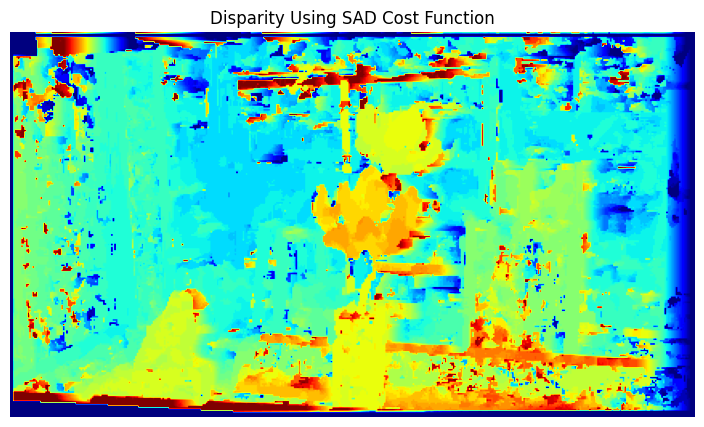

In [15]:
disp = block_matching( img_R_resized / 255, img_L_resized / 255, F, SAD, ndisp_resized)

# scale the range of disparity into [0-1]
disp = np.float32( disp - disp.min()) / np.float32( disp.max())

ssim_L = structural_similarity( disp_L_resized_scaled, disp, data_range=1)
ssim_R = structural_similarity( disp_R_resized_scaled, disp, data_range=1)

print( f"SSIM with Left Disparity: { ssim_L}")
print( f"SSIM with Right Disparity: { ssim_R}")
print( f"Mean SSIM: { np.mean( [ ssim_L, ssim_R])}")

plt.figure( figsize=( 10, 5))
plt.imshow( disp, cmap="jet")
plt.title( "Disparity Using SAD Cost Function")
plt.axis( "off")
plt.show()